In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi

Tue Mar 30 03:07:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

from keras.datasets import mnist
from keras.optimizers import Adam
from keras.initializers import RandomNormal

## 1. Load MNIST Dataset
- 'generator'의 'tanh' activation 출력에 적합하도록 정규화

In [5]:
(X_train, y_train) , (X_test, y_test) = mnist.load_data()

# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
# 마지막 activation을 tanh 쓴다(-1 ~ 1 사이)
# 정규화할 때 127.5 - 1 을 하면 -1~1 사이 값

# Reshape
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


## 2. 'adam' Optimizer
- beta_1: 감쇠율 조정

In [6]:
# adam에 학습율을 지정하기 위해 keras adam import
# beta_1: 감쇠율
adam = Adam(lr = 0.0002, beta_1 = 0.5)

## 3. 'generator' Model
- 랜덤벡터(잠재공간의 랜덤포인트)를 입력받아 이미지 생성
  - NOISE_DIM: 입력 랜덤 벡터 크기
- 'discriminator'를 속이도록 학습

In [7]:
NOISE_DIM = 10

generator = Sequential(name = 'generator') # sequential 모델로 쌓음

generator.add(Dense(256, input_shape = (NOISE_DIM,))) # 10개짜리 noise를 집어넣은 것
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh')) # 끝에는 784개가 나오도록 구성

# Generator 구조를 convolutional로 바꾸면 DC GAN(Deep Convolutional GAN)

- Model Summary

In [8]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               80

## 4. 'discriminator' Model
- 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image'인지 판별
  - 이진분류

In [9]:
discriminator = Sequential(name = 'discriminator')

discriminator.add(Dense(1024,
                        input_shape = (784,),
                        kernel_initializer = RandomNormal(stddev = 0.02)))
                        # 초기화값: random normal (학습속도가 좀 더 빨라짐)

discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))
# 최종으로는 fake인지 real인지 이진분류

# discriminator도 convolutional 가능

In [10]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

### 1) 'discriminator' Compile
- 학습설정

In [11]:
discriminator.compile(loss = 'binary_crossentropy', # 이진분류
                      optimizer = adam)

## 5. 'gan' Model

### 1) 'generator', 'discriminator' 연결
- 'gan' 모델에서 'generator'만 학습하도록 설정
  - discriminator.trainable = False

In [12]:
# generator는 구조만 주고 compile을 안함(학습방법을 지정하지 않음)
# generator와 discriminator는 동시에 학습되면 안된다
# generator와 discriminator를 합쳐서 학습하도록 설정

# discriminator를 freeze함 (학습되지 않음)
discriminator.trainable = False


gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

### 2) 'gan' Model

In [13]:
gan = Model(gan_input, output, name = 'gan')

### 3) 'gan' Summary

In [14]:
gan.summary()
# generator의 파라미터들은 업데이트됨

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


### 4) 'gan' Compile
- 학습 설정

In [15]:
gan.compile(loss = 'binary_crossentropy', # discriminator를 속였냐, 속이지 못했냐의 이진분류
            optimizer = adam)

## 6. Define 'get_batches()' Function
- MNIST image batch 생성

In [16]:
# real: 128개, fake: 128개, 총 256개를 뽑아서 학습시키는 함수 정의

def get_batches(data, batch_size) :
  batches = []

  for i in range(data.shape[0] // batch_size) :
    batch = data[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  
  return np.asarray(batches)

## 7. 'visualize_training()' Function

In [17]:
def visualize_training(epoch, d_losses, g_losses):

  # 오차 시각화
  plt.figure(figsize = (8, 4))
  plt.plot(d_losses, label = 'Discriminator Loss')
  plt.plot(g_losses, label = 'Generator Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # 이미지 생성결과 시각화
  print('epoch: ' , epoch)
  noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
  generated_images = generator.predict(noise)
  generated_images = generated_images.reshape(-1, 28, 28)

  plt.figure(figsize = (8, 4))
  for i in range(generated_images.shape[0]):
    plt.subplot(4, 6, i + 1)
    plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

## 8. Model Training
- 약 35분
- .fit()
  - 'epoch', 'batch_size' 지정
- .train_on_batch()
  - 전달받은 모든 데이터를 사용하여 학습 진행
- 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch()' 사용

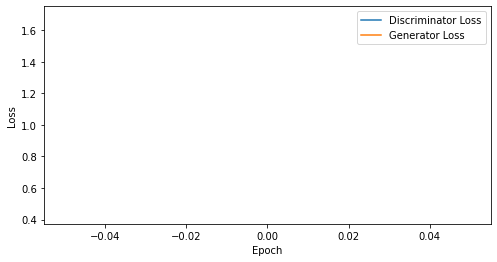

epoch:  1


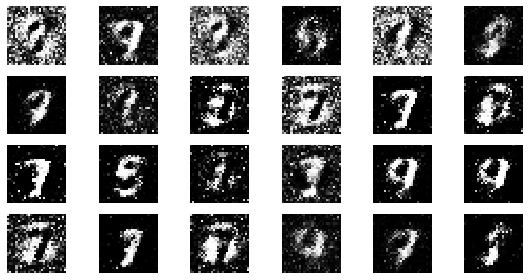

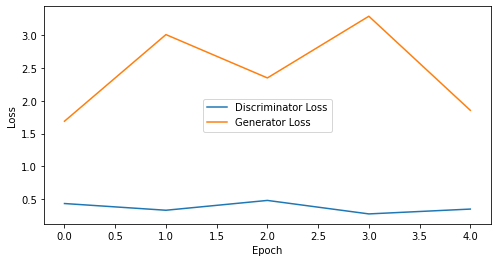

epoch:  5


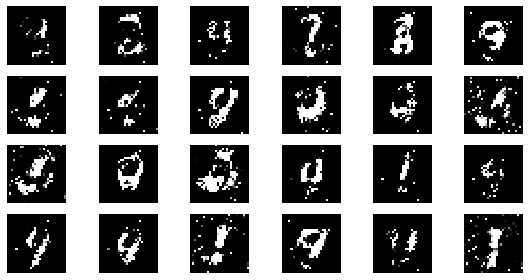

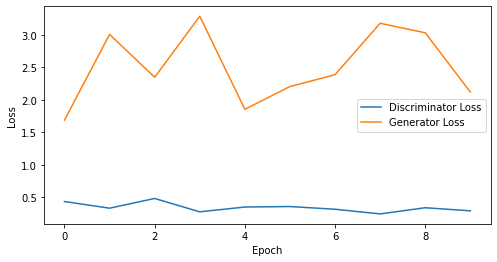

epoch:  10


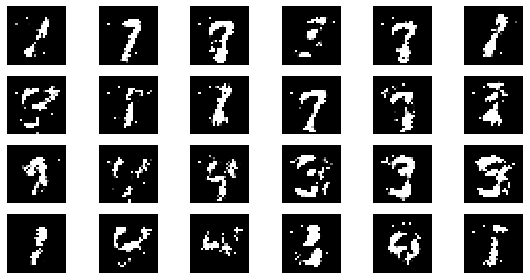

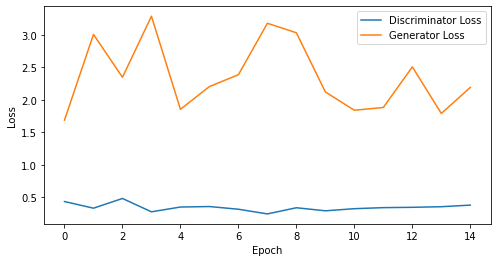

epoch:  15


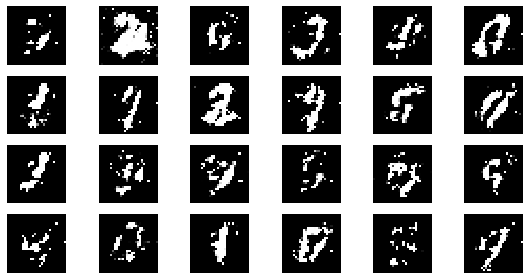

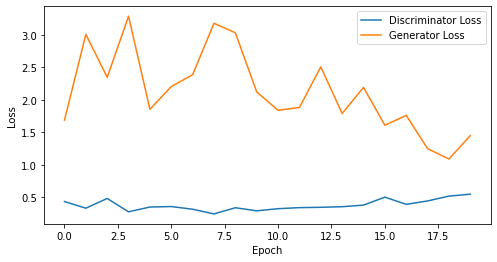

epoch:  20


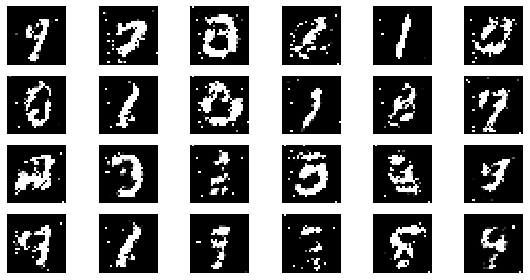

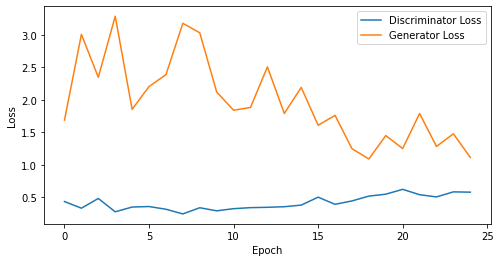

epoch:  25


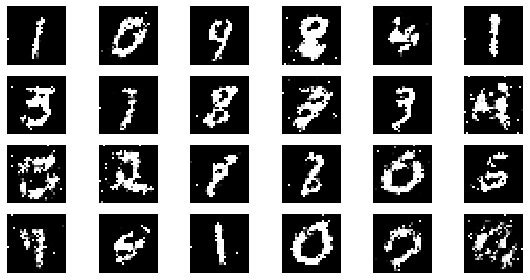

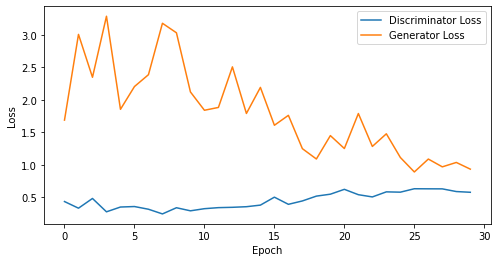

epoch:  30


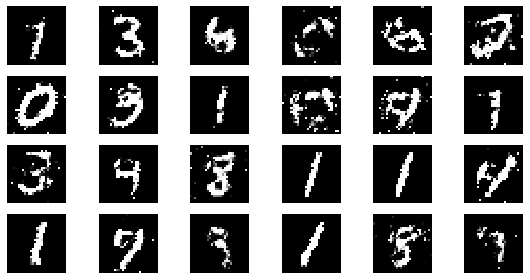

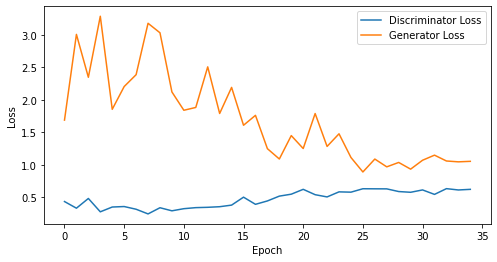

epoch:  35


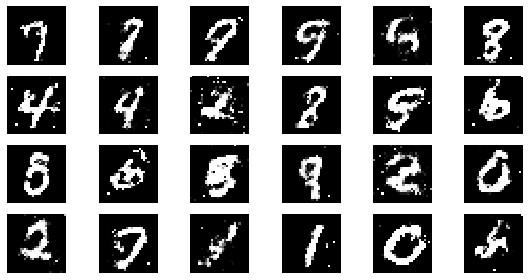

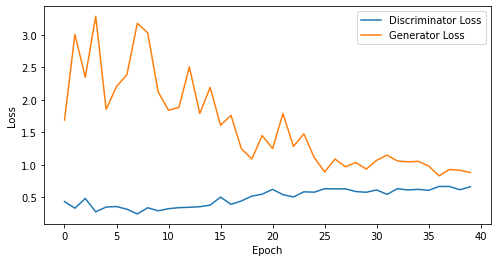

epoch:  40


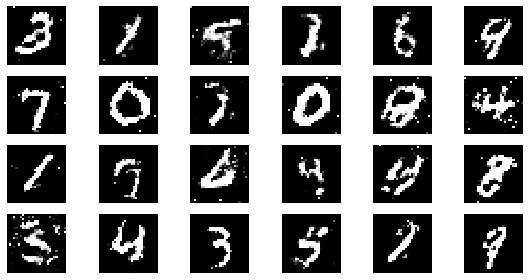

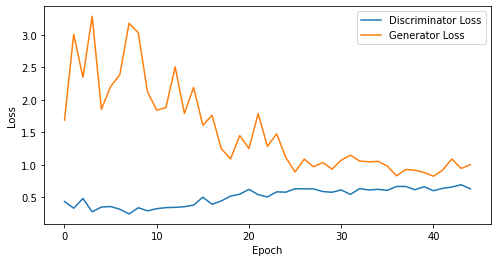

epoch:  45


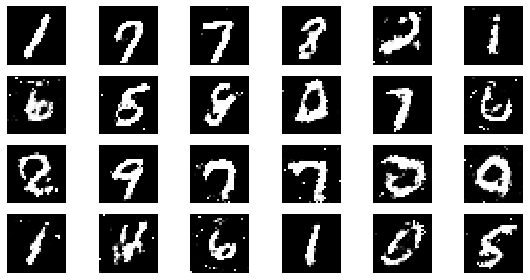

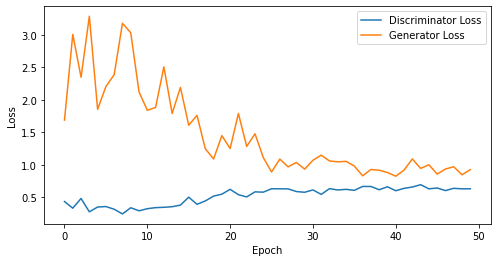

epoch:  50


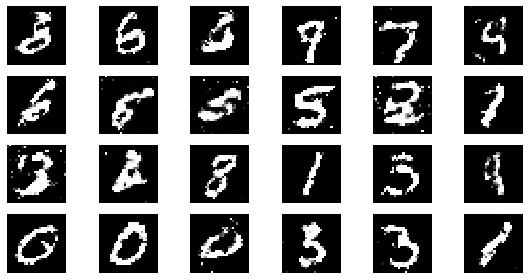

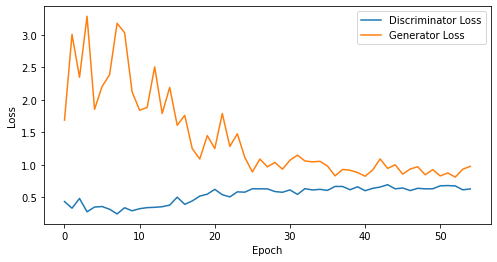

epoch:  55


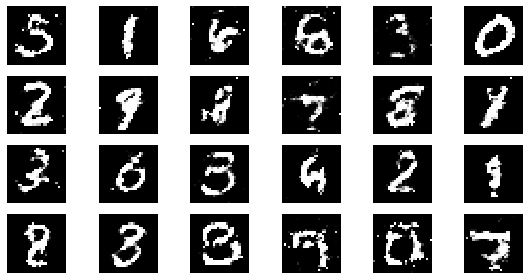

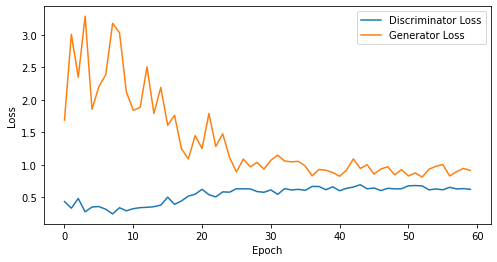

epoch:  60


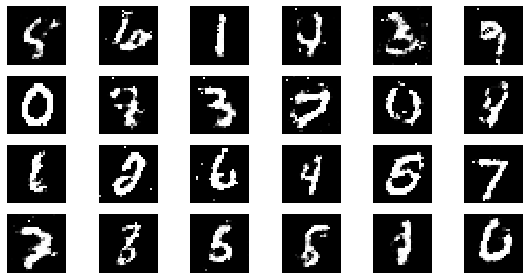

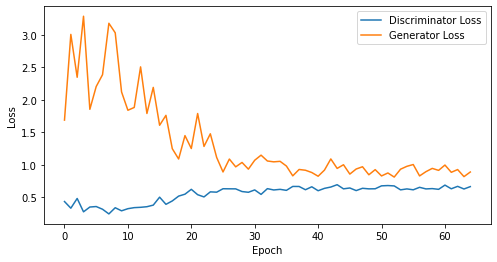

epoch:  65


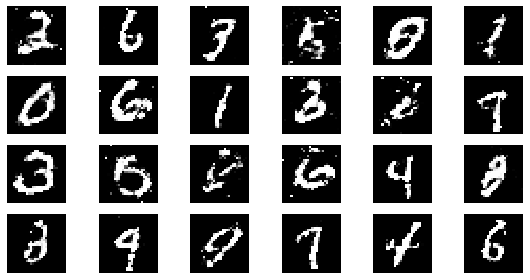

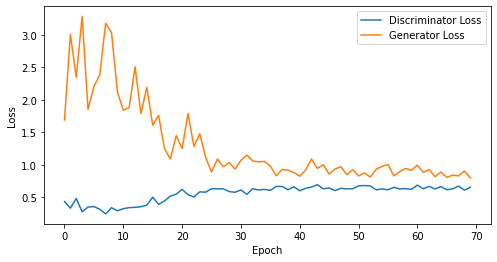

epoch:  70


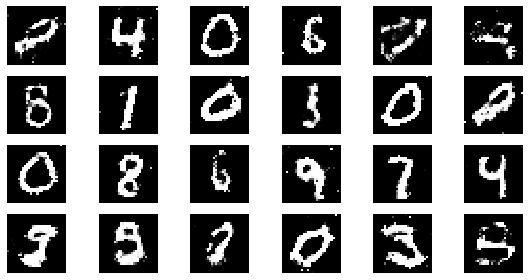

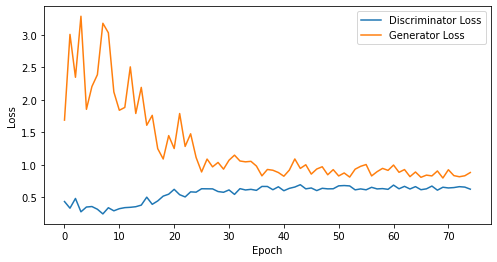

epoch:  75


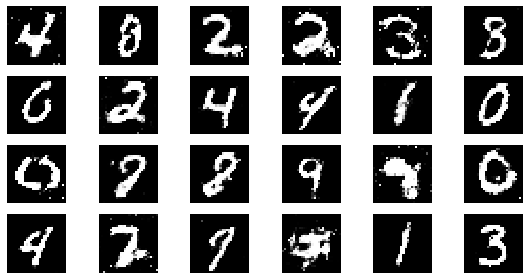

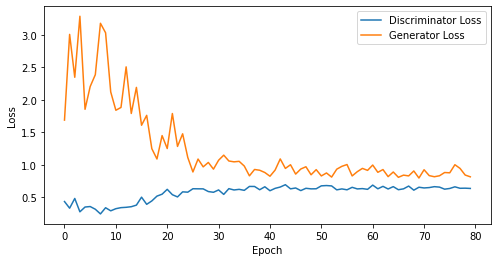

epoch:  80


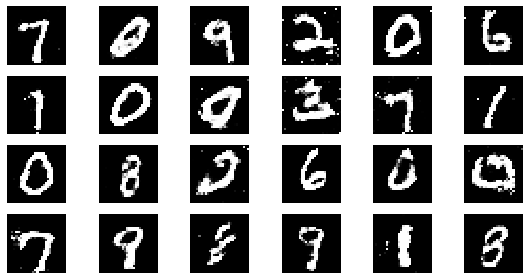

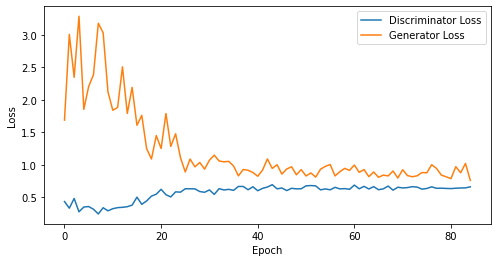

epoch:  85


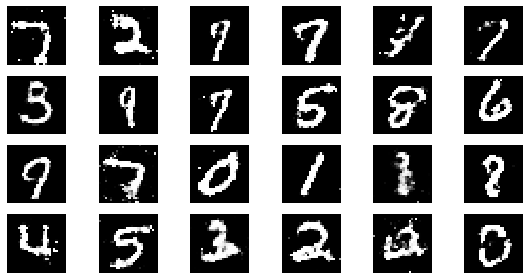

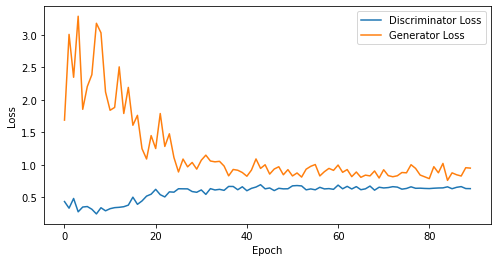

epoch:  90


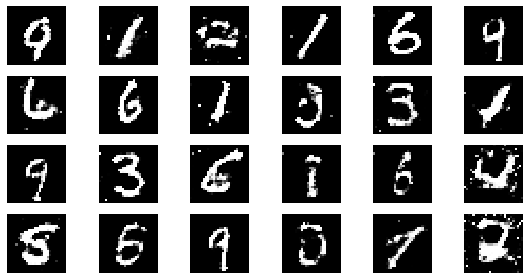

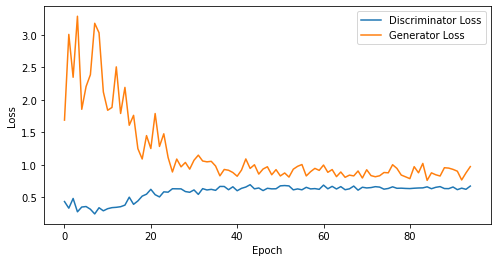

epoch:  95


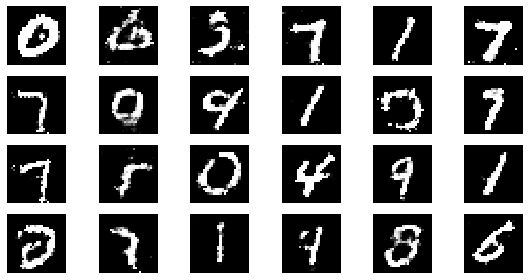

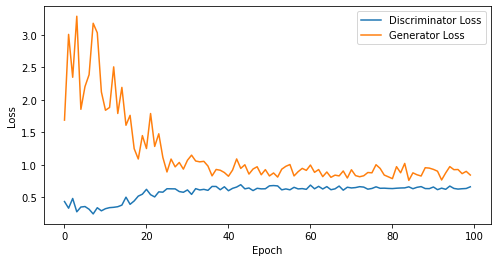

epoch:  100


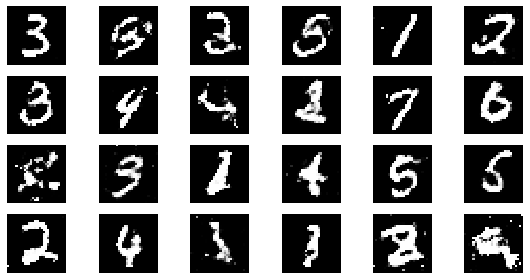

CPU times: user 31min 13s, sys: 1min 29s, total: 32min 42s
Wall time: 30min 41s


In [18]:
%%time

EPOCHS = 100
BATCH_SIZE = 128

# 'discriminator' , 'gan' loss 저장 리스트
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1): # epoch 1부터 하려고 range(1, epochs + 1)
  # batch 별 학습
  for real_images in get_batches(X_train, BATCH_SIZE) :
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
    # uniform: normal distribution으로 넣으면 어떨까?

    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise)

    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])
    # X_train에서 real_image가 나오고, generator에서 generate_image가 나와서
    # np.concatenate: 일렬로 쌓인 매트릭스 생성
    # [ real ] [ label ]
    # [ fake ] [ label ]

    # 'gan' 학습용 y 데이터 정의
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 1  # labeling: 앞쪽이 real(1), 뒤쪽이 fake(0)

    
    # 'discriminator' 학습
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)
    # train_on_batch: fit과 같으나, 전달받은 모든 데이터를 사용하여 학습

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)

    # 'discriminator' 학습 정지
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  # 생성 결과 시각화
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)